<a href="https://www.kaggle.com/code/cleytoncandeira/titanic-survived-2022-1st-competition?scriptVersionId=116022305" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Kaggle Competition Titanic

## Cleyton Candeira

- Initial words:

    * The Titanic challenge aims to estimate which survivors of the tragedy. To do this, we have a database that takes into account features such as: 1) Ticket class; 2) Sex; 3) Age; 4) Passenger Fare and etc. It is known that in the context of the tragedy passengers boarded with family, with friends, and that the plot of the classic Oscar-winning film concerns how the integrity of relationships "survived" this huge catastrophe. 
    * At first sight we can posit that there are more categorical than numerical variables. This preliminarily hints that the Machine Learning model to be built will be fed predominantly by categorical variables. Even if it is necessary to convert numerical variables into categorical variables by means of transformations.
    * In this exercise we can test some classifiers such as Random Forest and Neural Network algorithms

## Data Import/Treatment

### Missing Values

* The processing of the data will not be done in an amateurish manner. Following a data treatment check-list, we list as the first step the analysis of missing values within the database. 

In [1]:
#hands-on work packages

import numpy as np
import pandas as pd
import copy

#graphs

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
# Import data

train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
gs = pd.read_csv('../input/titanic/gender_submission.csv')

#shape

train_s = train.shape

#concat train/test

my_data = pd.concat([train, test], sort = True, ignore_index = True)

datum = my_data.copy(deep = True)

#check NAN values and evaluate cols
    
def check_nan_values(dataset):
    percent_missing = dataset.isnull().sum() * 100 / len(dataset)
    missing_values_diag = pd.DataFrame({'Features': dataset.columns, 
                                           'Percent Missing': percent_missing}
                                      ).reset_index(drop = True)
        
    return missing_values_diag # dataframe diag
    
check_nan_values(datum)

,Features,Percent Missing
0,Age,20.091673
1,Cabin,77.463713
2,Embarked,0.152788
3,Fare,0.076394
4,Name,0.000000
5,Parch,0.000000
6,PassengerId,0.000000
7,Pclass,0.000000
8,Sex,0.000000
9,SibSp,0.000000


### Cabin

- Although the Cabin feature has more missing values than the others (77.46% of missing values), we have good reason to understand it with more complexity. The accommodation of each passenger was done by class, and each class was inserted in a certain deck. According to the database, it cannot be stated precisely where a particular passenger was accommodated. However, by turning this feature into a valid feature we can keep the richness of the information it contains without discarding it. 

In [3]:
#Create new Feat from col Cabin

datum['Cabin'].fillna('U', inplace = True) #Fill NaN values with "Unknown"
    
datum['Cabin'] = [i[0] for i in datum['Cabin']] #Extract Deck information

### Title Names

* It is worth noting that the names carry titles of the time, such as Master, Lord, Lady, Miss, and so on. These variables relate to the Deck, the Class, and the amount paid on the ticket. It is worth remembering that in the movie the socioeconomic inequality on the Titanic was something very clear and expressive, which may (or may not) have been expressed also by the survivors. 

In [4]:
#Create new features from col Name: TitleNames

new_col = []

for x in datum['Name']:
    temp = x.replace('.', ',')
    temp = temp.split(',')
    temp.pop()
    temp = list(map(lambda x: x.strip(), temp))
    new_col.append(temp[1])

datum['TitleNames'] = new_col

### Fare and create FarePP

* The `Fare` feature has 0.076% missing data. Similarly to 'Embarked', we will not directly apply any statistical interpolation metrics, however, we will first analyze the context in which your problem is embedded. 

In [5]:
#Look at Fare

datum[datum['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,TitleNames
1043,60.5,U,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr


* 0.076% corresponds to only one missing piece of data. 
* We can extract that Mr. Thomas (Shelby, joke) is a lonely 60-year-old man, without families, or friends (not yet known), who has boarded in S, in 3rd Class. So let's filter out who traveled alone, boarded in S, and was in 3rd Class to find out the median rate he paid to tragically travel on the Titanic.
    - Attention: the median will be used instead of the mean because the distribution has a lot of dispersion and is non-normal. 
* Based on the ticket price, we must find the price per person who traveled with one or more other people. `Fare per 
person`, in this case, can be define: ticket price divided by the number of the passenger who share the same ticket. Therefore, this parameter is able to provide us individually with the price paid for each ticket and, in this way, it is possible to calculate its median for the missing values.

In [6]:
df_ticket = datum.groupby([
                            'PassengerId',
                            'Embarked', 
                            'Pclass',
                            'Ticket'],
                                    as_index = False).agg({'Fare': 
                                                           ['count', 
                                                            'sum'], 
                                                                     })

df_ticket['FarePP'] = df_ticket['Fare']['sum']/df_ticket['Fare']['count']

faremiss = df_ticket[
            (df_ticket['Fare']['count'] == 1) & #filter if he is alone
            (df_ticket['Embarked'] == 'S') & #filter if he is on S port
            (df_ticket['Pclass'] == 3)] #filter him class

datum['Fare'].fillna(np.median(faremiss['FarePP']), inplace = True) #replace with median fare

In [7]:
#Add Fare_PP like new feature in datum

datum['FarePP'] = df_ticket['FarePP'].copy(deep = True)

In [8]:
datum[datum['FarePP'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,TitleNames,FarePP
1041,23.0,C,C,83.1583,"Earnshaw, Mrs. Boulton (Olive Potter)",1,1042,1,female,0,NaN,11767,Mrs,NaN
1307,NaN,U,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,Mr,NaN
1308,NaN,U,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668,Master,NaN


* These missing values are likely to have been generated because these individuals do not share tickets. Will be?

In [9]:
def fill_nan_fare_pp(row, embarked, pclass):
    data_frame = df_ticket[(df_ticket['Fare']['count'] == 1) & 
                        (df_ticket['Embarked'] == embarked) & 
                        (df_ticket['Pclass'] == pclass)]
    datum.loc[row, ['FarePP']] = np.median(data_frame['FarePP']) 
    
    return datum

datum = fill_nan_fare_pp(1041, 'C', 1)
datum = fill_nan_fare_pp(1307, 'S', 3)
datum = fill_nan_fare_pp(1308, 'C', 3)

### Embarked

* Now let's check the boarding ports of each passenger. The feature has 15.27% missing values and it will be unreasonable to simply use a statistical metric (such as mode or median) to fill in its remaining values. First we must analyze in which context these missing values are placed, since title, class and rate are significant variables. 

In [10]:
#fix Embarked feature

datum[datum['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,TitleNames,FarePP
61,38.0,B,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,83.475
829,62.0,B,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,18.750


- There are two methods of finding out the boarding port of the two missing passengers: i) if the ticket is shared, the same port that the spouse boarded will be the boarding port of this passenger; ii) the estimation of the ticket value.

    - Well, at first sight, Miss Amelie is unmarried woman (?).

In [11]:
#Found Mrs Stone's Husband

datum[datum['Name'].str.contains("Nelson | Stone", case = False)]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,TitleNames,FarePP
319,40.0,E,C,134.5000,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",1,320,1,female,1,1.0,16966,Mrs,7.2500
621,42.0,D,S,52.5542,"Kimball, Mr. Edwin Nelson Jr",0,622,1,male,1,1.0,11753,Mr,15.7417
829,62.0,B,NaN,80.0000,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,18.7500
935,45.0,D,S,52.5542,"Kimball, Mrs. Edwin Nelson Jr (Gertrude Parsons)",0,936,1,female,1,NaN,11753,Mrs,29.7000


- Answer: Mrs Martha Evelyn is a widow, baseded on your age, or traveled alone, which doesn't seem to be a likely situation. However, since the both, Mrs Martha and Miss Amelie, share the exact same ticket, it is concluded that they traveled together. Then we will check if anyone else shares the ticket of the two crew members...

In [12]:
datum[datum['Ticket'] == '113572']

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,TitleNames,FarePP
61,38.0,B,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,83.475
829,62.0,B,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,18.750


- With this answer, we can tell that there are other crew members who share the same ticket. This information is given in`SibSp` and `Parch`. However, this is not the necessary information, because it does not tell about the price of the companion ticket.

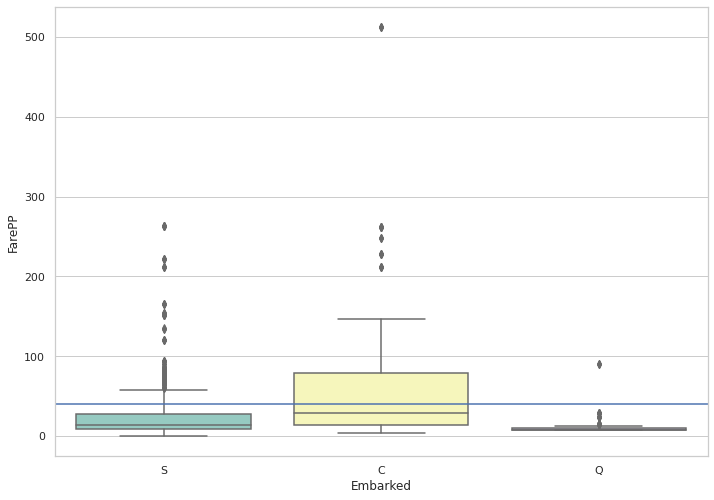

In [13]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.set_style("whitegrid")

ax = sns.boxplot(data = df_ticket[['Embarked', 'Pclass', 'Ticket', 'FarePP']], 
                 y="FarePP", x="Embarked", palette="Set3")

ax.axhline(40)

* Looking at the box-plot results, we can say that the fee per person could not be paid by someone who boarded in either S or Q, which have lower medians of fees paid. To consider S or Q would be to consider an outlier. In this sense, it is reasonable to say that the two passengers, who paid 40 per person, boarded at C.

In [14]:
datum['Embarked'].fillna('C', inplace = True)

datum[datum['Ticket'] == '113572']

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,TitleNames,FarePP
61,38.0,B,C,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,83.475
829,62.0,B,C,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,18.750


### FamilySize, FriendSize, and GroupSize

* We can determine a feature called `FamilySize`. The family size is the sum of the person himself (1) plus siblings or spouse plus parents and child.

 $FamilySize = SibSp + Parch + 1$
 
* Do mesmo modo, determinamos outro feature dos passageiros que viajaram acompanhados mas não possuem nenhum laço de parentesco, `FriendSize`.

 $FriendSize = sum(count(ticketshared))$
 
* Em termos gerais, determinamos um terceiro feature derivado de`FamilySize` e `FriendSize`, ao qual será o valor máximo obtido de ambos:

 $GroupSize = max(FamilySize, FriendSize)$
 
 

In [15]:
#Attention! df_ticket must be correct to use fare-count! So...

df_ticket_correct = datum.groupby([
                            'PassengerId',
                            'Embarked', 
                            'Pclass',
                            'Ticket'],
                                    as_index = False).agg({'Fare': #new Fare col with new values (median adjust)
                                                           ['count', 
                                                            'sum'], 
                                                                     })
#Create FamilySize, FriendSize and GroupSize

datum['FamilySize'] = datum['SibSp'] + datum['Parch'] + 1

datum['FriendSize'] =  df_ticket_correct['Fare']['count'].copy(deep = True)

datum['GroupSize'] = datum[['FamilySize', 'FriendSize']].max(axis = 1)

### Age and LifeStage

* From the Titanic Machine Learning from Disaster challenge fill in the `Age` feature is the one that separates the men from the boys literally. So we have that all values are numeric and are in `float64`. 
* `Age` contains 20.09% missing values, and this cannot be interpolated using a basic metric of median, mean, or any other improvised "splice". Assuming that the fraction of values .4, .5, .3, represent the monthly share of each passenger's age, we can separate one set of data for training linear regression and another set for testing.  

In [16]:
#Predict Age missing values

from sklearn.preprocessing import LabelEncoder # Standardize the values
from sklearn.linear_model import LinearRegression # Linear Reg

le = LabelEncoder()
lr = LinearRegression()

#Let's started...

#First, we need to see correlation map (it's necessary to drop non-sinigicant cols)

corr_data = datum.corr()

corr_data[corr_data['Age'] <= - 0.15], corr_data[corr_data['Age'] >= 0.15]

(                 Age      Fare     Parch  PassengerId    Pclass     SibSp  \
 Parch      -0.150917  0.221668  1.000000     0.008942  0.018322  0.373587   
 Pclass     -0.408106 -0.558740  0.018322    -0.038354  1.000000  0.060832   
 SibSp      -0.243699  0.160388  0.373587    -0.055224  0.060832  1.000000   
 FamilySize -0.240229  0.226653  0.792296    -0.031437  0.050027  0.861952   
 GroupSize  -0.240229  0.226653  0.792296    -0.031437  0.050027  0.861952   
 
             Survived    FarePP  FamilySize  FriendSize  GroupSize  
 Parch       0.081629  0.076272    0.792296         NaN   0.792296  
 Pclass     -0.338481 -0.032459    0.050027         NaN   0.050027  
 SibSp      -0.035322  0.020606    0.861952         NaN   0.861952  
 FamilySize  0.016639  0.055241    1.000000         NaN   1.000000  
 GroupSize   0.016639  0.055241    1.000000         NaN   1.000000  ,
            Age      Fare     Parch  PassengerId    Pclass     SibSp  Survived  \
 Age   1.000000  0.177286 -0.1509

- Select by corr criterion: 
        - Parch
        - Pclass
        - GroupSize
        - Fare

In [17]:
#Go, go, go...

lr_age_set = datum[['Age', 'Parch', 'Pclass', 'GroupSize', 'Fare']].copy(deep = True)

train_age = lr_age_set[lr_age_set['Age'].notnull()].copy(deep = True) #train set
test_age = lr_age_set[lr_age_set['Age'].isnull()].copy(deep = True) #test set

y = le.fit_transform(train_age['Age']) #define train target

train_age.drop(columns = ['Age'], inplace = True) #define train features
test_age.drop(columns = ['Age'], inplace = True) #define test features

#encoding features train_age and test_age

for i in train_age:
    train_age[i] = le.fit_transform(train_age[i])
    test_age[i] = le.fit_transform(test_age[i])

#linear reg

lr.fit(train_age, y)

train_age['Age'] = y

test_age['Age'] = lr.predict(test_age)

#concat 
df_age = [train_age, test_age] #all
df_age = pd.concat(df_age)

#copy to datum

datum['Age'] = df_age['Age'].copy(deep = True)

- The best way to work with ages is to turn `Age` into categorical variables. Young, adult, child, elderly, and so on. However, let's check the official United States `Life Stage`. It is: Infant, Toddler, Children, Teenager, Adult, Middleage and Senior.

In [18]:
lifestages = ['Infant', 'Toddler', 'Children', 
             'Teenager', 'Adult', 'MiddleAge', 'Senior']

bins = [0, 1, 4, 12, 19, 39, 59, 100]


datum['LifeStage'] = pd.cut(datum['Age'],    #Now, Pandas is my personal hero to save me in few rows!
                                bins = bins, 
                               labels = lifestages)

In [19]:
datum[datum['LifeStage'].isnull()] #But, nothing is perfect...

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,TitleNames,FarePP,FamilySize,FriendSize,GroupSize,LifeStage
1245,0.0,U,S,20.575,"Dean, Miss. Elizabeth Gladys Millvina""""",2,1246,3,female,1,NaN,C.A. 2315,Miss,51.4792,4,1,4,NaN


In [20]:
#To check his ticket, if she can be a newborn...

datum[datum['Ticket'] == 'C.A. 2315']

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,TitleNames,FarePP,FamilySize,FriendSize,GroupSize,LifeStage
93,39.0,U,S,20.575,"Dean, Mr. Bertram Frank",2,94,3,male,1,0.0,C.A. 2315,Mr,7.2500,4,1,4,Adult
788,7.0,U,S,20.575,"Dean, Master. Bertram Vere",2,789,3,male,1,1.0,C.A. 2315,Master,79.2000,4,1,4,Children
923,50.0,U,S,20.575,"Dean, Mrs. Bertram (Eva Georgetta Light)",2,924,3,female,1,NaN,C.A. 2315,Mrs,57.7500,4,1,4,MiddleAge
1245,0.0,U,S,20.575,"Dean, Miss. Elizabeth Gladys Millvina""""",2,1246,3,female,1,NaN,C.A. 2315,Miss,51.4792,4,1,4,NaN


- Acording my Guroogle, "The use of Master as a prefixed title is, according to Leslie Dunkling, "a way of addressing politely a boy ... too young to be called 'Mister'." (to check: https://en.wikipedia.org/wiki/Master_(form_of_address)). Which means something totally plausible for a 7-year-old boy to have a "Master" title. But, and Miss for a newborn? Does it make sense that Mrs. Bertram, a middle-aged wife, specifically in her 50s, could have borne the pregnancy and given birth in the middle of 1912?
    - Yes! Elizabeth Gladys was only nine weeks old and survived! (https://www.sandiegouniontribune.com/sdut-1n1titanic23582-infant-titanic-she-was-last-surviv-2009jun01-story.html), but his mother, Eva, doesn't has 50, but, in real, 32 (https://www.encyclopedia-titanica.org/titanic-survivor/eva-georgetta-dean.html)
    - The categorization error happens because the range 0.0 is not including in "Infant". We can solve this manually or redo the algorithm, what to do?
        - Curiosity: in Brazil (my homeland) newborns do not pay boarding fees in any transport. This is to see how American capitalism once again works. 
    - After research on Pandas "cut" method, I found this here, (https://towardsdatascience.com/all-pandas-cut-you-should-know-for-transforming-numerical-data-into-categorical-data -1370cf7f4c4f), which briefly says that the lowest value is normally not included in the categorization. So let's include it, shall we?
    - Please don't exclude Elizabeth this time like we've done in the past just because she wasn't cast in the movie and nobody gave a damn about her.

In [21]:
datum['LifeStage'] = pd.cut(datum['Age'], 
                                bins = bins, 
                               labels = lifestages,
                               include_lowest = True #Please!
                           )

In [22]:
def family_group(size):
    b = ''
    if (size <= 1):
        b = 'Alone'
    elif (size <= 4):
        b = 'Small'
    else:
        b = 'Large'
    return b

# Creating family_group by its size (in both dataset and Submission)
datum['FamilyGroup'] = datum['FamilySize'].map(family_group)

In [23]:
df = datum.drop(columns = ['Age', 'Name', 'SibSp', 'Parch', 'Ticket', 'PassengerId', 'Survived', 
                                'FamilySize', 'GroupSize', 'FriendSize', 'Fare'])

In [24]:
df.isnull().sum()

Cabin          0
Embarked       0
Pclass         0
Sex            0
TitleNames     0
FarePP         0
LifeStage      0
FamilyGroup    0
dtype: int64

## Data Modelling

In [25]:
#Modelling -- Modules

#sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier

#anothers
from xgboost.sklearn import XGBClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

/opt/conda/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [26]:
#scaler by pandas

new_datum = pd.get_dummies(df, drop_first = True)

In [27]:
train_ml = copy.deepcopy(new_datum.iloc[:train_s[0], :])
train_ml['Survived'] = my_data['Survived']
test_ml = copy.deepcopy(new_datum.iloc[train_s[0]:, :])
test_ml['PassengerId'] = my_data['PassengerId']

In [28]:
y = train_ml['Survived']
X = train_ml.drop(columns = 'Survived')

In [29]:
#Split to cross-validation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [30]:
def find_the_best_of_the_best_model(X_train, X_test, y_train, y_test):
    # Logistic Regression
    logreg = LogisticRegression(max_iter = 600, random_state = 42)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    logreg_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Decision Tree
    decision_tree = DecisionTreeClassifier(random_state = 42)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    decision_tree_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Random Forest
    random_forest = RandomForestClassifier(random_state = 42)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    random_forest_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # XGBoost
    xgb = XGBClassifier(random_state = 42)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    xgb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # GBM
    gbm = GradientBoostingClassifier(random_state = 42)
    gbm.fit(X_train, y_train)
    y_pred = gbm.predict(X_test)
    gbm_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # LightGBM
    lgbm = LGBMClassifier(random_state = 42)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    lgbm_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
        
    # Catboost
    catb = CatBoostClassifier(verbose = 0, random_state = 42)
    catb.fit(X_train, y_train)
    y_pred = catb.predict(X_test)
    catb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Histogram-based Gradient Boosting Classification Tree
    hgb = HistGradientBoostingClassifier(random_state = 42)
    hgb.fit(X_train, y_train)
    y_pred = hgb.predict(X_test)
    hgb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    model_df = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'GBM', 'LightGBM', 'Catboost', 'HistBoost'],
                       'Score': [logreg_acc, decision_tree_acc, random_forest_acc, xgb_acc, gbm_acc, lgbm_acc, catb_acc, hgb_acc]})
    print(model_df.sort_values('Score', ascending = False).reset_index(drop = True))


In [31]:
find_the_best_of_the_best_model(X_train, X_test, y_train, y_test)

                 Model  Score
0              XGBoost  83.24
1             LightGBM  82.68
2  Logistic Regression  82.12
3                  GBM  81.56
4             Catboost  81.56
5            HistBoost  81.56
6        Random Forest  76.54
7        Decision Tree  73.74


In [32]:
gbm_param_grid = {
    'n_estimators': range(8, 20),
    'max_depth': range(6, 10),
    'learning_rate': [.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1]
}

# Instantiate the regressor: gbm
gbm = XGBClassifier(n_estimators=10)

# Perform random search: grid_mse
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                    estimator = gbm, scoring = "accuracy", 
                                    verbose = 1, n_iter = 50, cv = 4)

# Fit randomized_mse to the data
xgb_random.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_random.best_params_)
print("Best accuracy found: ", xgb_random.best_score_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best parameters found:  {'n_estimators': 11, 'max_depth': 6, 'learning_rate': 0.45, 'colsample_bytree': 1}
Best accuracy found:  0.8204561063305458


In [33]:
X_new_test = test_ml.drop(columns =['PassengerId'])
xgb_pred = xgb_random.predict(X_new_test)

In [34]:
output = pd.concat([test.PassengerId, pd.DataFrame(xgb_pred)], axis = 'columns')
output.columns = ["PassengerId", "Survived"]
output.to_csv('titanic_submission.csv', header = True, index = False)